In [71]:
import numpy as np 
from matplotlib import pyplot as plt
from numba import jit

In [72]:
L=500


In [73]:
@jit(nopython=True)
def custom_roll1(arr, shift):
    rows, cols = arr.shape
    shift %= cols  
    result = arr.copy()
    for i in range(rows):
        result[i] = np.roll(arr[i], shift)
    return result

@jit(nopython=True)
def custom_roll0(arr, shift):
    rows, cols = arr.shape
    shift %= rows
    result = arr.copy()
    for j in range(cols):
        result[:, j] = np.roll(arr[:, j], shift)
    return result

In [74]:
@jit(nopython=True)
def MCstep(lattice, T):
    L = len(lattice)
    for _ in range(L*L):
        n = np.random.randint(0, L)
        m = np.random.randint(0, L)
        h = 0
        for pos in [(m, (n+1)%L), (m, (n-1)%L), ((m+1)%L, n), ((m-1)%L, n)]:
            h+=lattice[pos] 
        delta = 2*lattice[m, n]*h
        r = np.random.rand()
        if r < np.exp(-1/T * delta):  #dwa warunki na raz
            lattice[m, n] *= -1




In [75]:
@jit(nopython=True)
def korelacja(lattices):
    L = len(lattices[0])
    kor = np.zeros((4, int(L/2)))
    for i in range(4):
        for r in range(int(L/2)):
            kor[i, r] = np.sum(lattices[i] * custom_roll1(lattices[i], r)) / L / L
    return kor
        

In [76]:
@jit(nopython=True)
def evolve(lattice):
    steps = [10, 100, 1000, 5000]
    res = []
    step=0
    while(step<=steps[-1]):
        MCstep(lattice, 2)
        if step in steps:   
            res.append(np.copy(lattice))
        step+=1
    return res

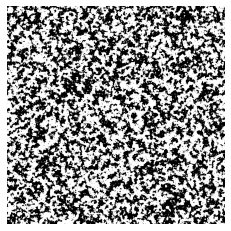

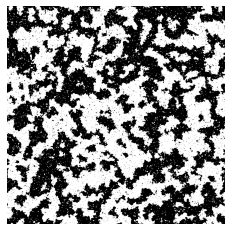

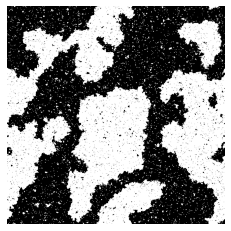

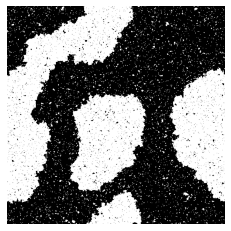

In [77]:
random_lattice = np.ones((L, L))
random_lattice = np.random.randint(0, 2, (L, L))
random_lattice = np.where(random_lattice==0, -1, 1)

steps =  np.array([10, 100, 1000, 5000])


res = evolve(random_lattice)

for l in res: 
    plt.imshow(l, cmap='Greys')
    plt.axis('off')
    plt.show()



c:\Users\mlata\anaconda3\lib\site-packages\numba\core\ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'lattices' of function 'korelacja'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\Users\mlata\AppData\Local\Temp\ipykernel_27080\3057753511.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


<Figure size 432x288 with 0 Axes>

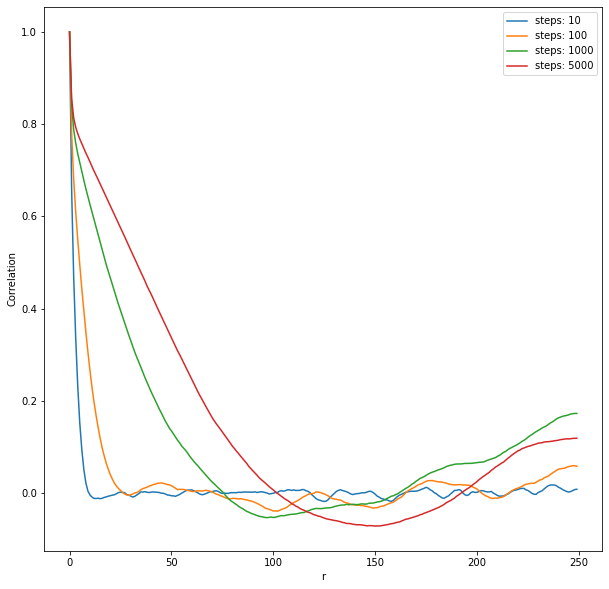

In [78]:

R = range(int(L/2))
plt.clf()

fig, ax = plt.subplots(figsize=(10, 10))
kor = korelacja(res)


for i in range(4):
    ax.plot(R, kor[i, :], label=f"steps: {steps[i]}")
    ax.set_xlabel("r")
    ax.set_ylabel("Correlation")
    
ax.legend()

CZĘŚĆ B

In [82]:
r_max = np.max(np.where(kor > 0.3, R, 0), axis=1)

R_size = np.zeros(4)

for i in range(4):
    kor_r = kor[i][R<=r_max[i]]
    R_size[i] = r_max[i]*(1+r_max[i])/ -2/ np.sum(np.log(kor_r))

print(R_size)



[ 2.66787591  7.03101252 24.60280995 43.4496143 ]


In [83]:
def line(x, a,b):
    return a*x+b


from scipy.optimize import curve_fit

Text(0, 0.5, 'Rozmiar domeny')

<Figure size 432x288 with 0 Axes>

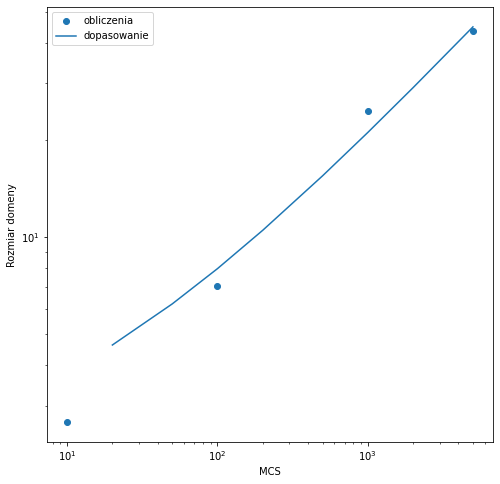

In [89]:
t_arr = np.array([20, 50, 100, 200, 500, 1000, 2000, 5000])
steps =  np.array([10, 100, 1000, 5000])


potp, pcov = curve_fit(line, np.sqrt(steps), R_size)

plt.clf()


fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(steps, R_size, label = 'obliczenia')
ax.plot(t_arr, potp[0]*np.sqrt(t_arr)+potp[1], label="dopasowanie")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("MCS")
ax.legend()
ax.set_ylabel("Rozmiar domeny")





DODATKOWE

In [112]:
@jit(nopython=True)
def evolve(lattice):
    steps = [100, 1000, 10000, 50000]
    res = []
    step=0
    while(step<=steps[-1]):
        MCstep(lattice, 2)
        if step in steps:   
            res.append(np.copy(lattice))
        step+=1
    return res


@jit(nopython=True)
def MCstep(lattice, T):
    L = len(lattice)
    for _ in range(L*L):
        n = np.random.randint(0, L)
        m = np.random.randint(0, L)
        i = np.random.randint(0, 4)
        (m2, n2) = [(m, (n+1)%L), (m, (n-1)%L), ((m+1)%L, n), ((m-1)%L, n)][i]
        h = 0
        if lattice[m, n] == lattice[m2, n2]:
            continue
        for pos in [(m, (n+1)%L), (m, (n-1)%L), ((m+1)%L, n), ((m-1)%L, n)]:
            if(pos!=(m2, n2)):
                h+=lattice[m, n]*lattice[pos] 
        for pos in [(m2, (n2+1)%L), (m2, (n2-1)%L), ((m2+1)%L, n2), ((m2-1)%L, n2)]:
            if(pos!=(m, n)):
                h+=lattice[m2, n2]*lattice[pos] 
        delta = 2*h
        r = np.random.rand()
        if r < np.exp(-1/T * delta):  #dwa warunki na raz
            idk = lattice[m, n]
            lattice[m, n] = lattice[m2, n2]
            lattice[m2, n2] = idk

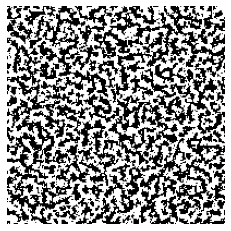

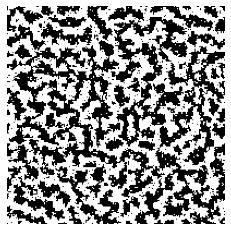

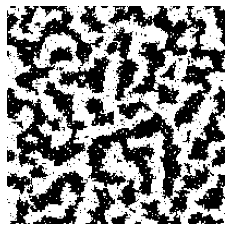

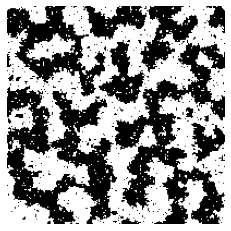

In [113]:
L = 200
steps = np.array([100, 1000, 10000, 50000])


random_lattice = np.ones((L, L))
random_lattice = np.random.randint(0, 2, (L, L))
random_lattice = np.where(random_lattice==0, -1, 1)


res = evolve(random_lattice)

for l in res: 
    plt.imshow(l, cmap='Greys')
    plt.axis('off')
    plt.show()


<Figure size 432x288 with 0 Axes>

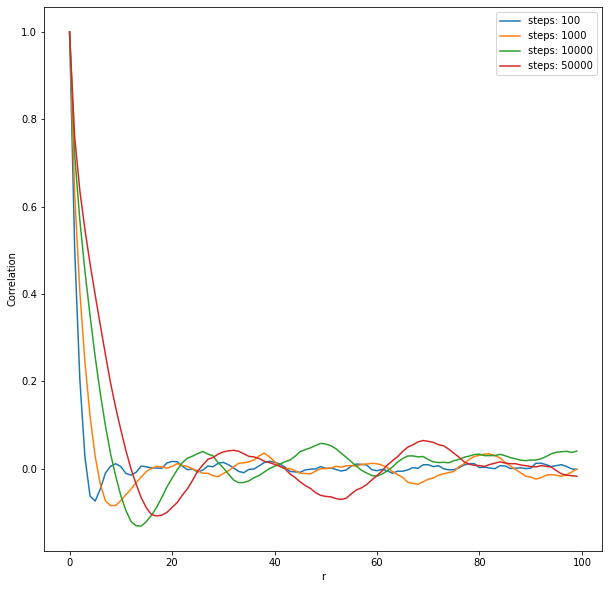

In [114]:

R = range(int(L/2))
plt.clf()

fig, ax = plt.subplots(figsize=(10, 10))
kor = korelacja(res)


for i in range(4):
    ax.plot(R, kor[i, :], label=f"steps: {steps[i]}")
    ax.set_xlabel("r")
    ax.set_ylabel("Correlation")
    
ax.legend()

In [115]:
r_max = np.max(np.where(kor > 0.3, R, 0), axis=1)

R_size = np.zeros(4)

for i in range(4):
    kor_r = kor[i][R<=r_max[i]]
    R_size[i] = r_max[i]*(1+r_max[i])/ -2/ np.sum(np.log(kor_r))

print(R_size)

[1.45147155 2.19731969 3.65478377 5.09847568]


Text(0, 0.5, 'Rozmiar domeny')

<Figure size 432x288 with 0 Axes>

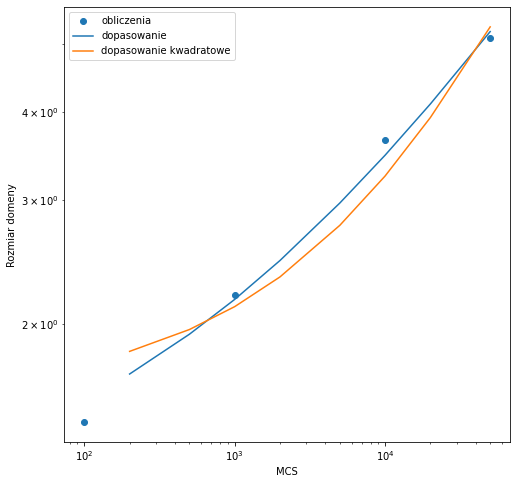

In [116]:
t_arr =10*np.array([20, 50, 100, 200, 500, 1000, 2000, 5000])


potp, pcov = curve_fit(line, steps**(1/3), R_size)
potp2, pcov = curve_fit(line, steps**(1/2), R_size)



plt.clf()


fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(steps, R_size, label = 'obliczenia')
ax.plot(t_arr, potp[0]*t_arr**(1/3)+potp[1], label="dopasowanie")
ax.plot(t_arr, potp2[0]*t_arr**(1/2)+potp2[1], label="dopasowanie kwadratowe")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("MCS")
ax.legend()
ax.set_ylabel("Rozmiar domeny")
